In [1]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import wandb
import tensorflow as tf
import os
import chardet
import pandas as pd
from transformers import TrOCRProcessor

AUTOTUNE = tf.data.AUTOTUNE
# [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
# 0
wandb.init(
    project="democtatii-TrOCR_test_v2.0-small",
    config={
        "batch_size": 32,
        "learning_rate": "[8.5e-5]",
        "weight_decay": 0,
        "num_epochs": 4,
        "optimizer": "adam",
        "max_target_length": 108,
    },
)

config = wandb.config

wandb: Currently logged in as: salim-nassor-sn. Use `wandb login --relogin` to force relogin


In [2]:
# Get the data
def get_data(_path):
    try:
        if os.path.isfile(_path):
            print('File exists')
            with open(_path, 'rb') as f:
                result = chardet.detect(f.read())
                _encoding = result['encoding']
                print(f'Encoding: {_encoding}')
            return pd.read_csv(_path, encoding="utf-8").dropna()
        else:
            print("Make sure the data is already prepared")
    except FileNotFoundError:
        print('File does not exist')

In [3]:
df = get_data('custom_data_two/image_labels_dataset.csv')
df.rename(columns={'image_path': 'file_name', 'label': 'text'}, inplace=True)
df.head()

File exists
Encoding: utf-8


,file_name,text
0,C:\Users\salim\Desktop\macos\pythonProject\cus...,Protokoll fört vid Upsala Sosial-
1,C:\Users\salim\Desktop\macos\pythonProject\cus...,Demokratiska Ungdomsklubb konstituerade
2,C:\Users\salim\Desktop\macos\pythonProject\cus...,möte Söndagen den 27 Desember 1903
3,C:\Users\salim\Desktop\macos\pythonProject\cus...,§ 1
4,C:\Users\salim\Desktop\macos\pythonProject\cus...,Mötet öppnades af Herr Kasttello hvarefter


In [4]:
#split the data
train_df, test_df = train_test_split(df, test_size=0.2)
# reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [5]:
# figure out max_length for our labels
def max_length(_df):
    max_len = 0
    for i in range(len(_df)):
        text = _df["text"][i]
        print(text)
        if len(text) > max_len:
            max_len = len(text)
    return max_len

In [6]:
max_target_length = max_length(train_df)
config.max_target_length = max_target_length + 2

Till kommitté för densamma valdes: Hrr
Tycko Hedén framhöll, gent emot
åt herrar El. Gustafsson och Rick. Bergström
Professor H. Öhrvall
föreslogs och antogs följande dagorning:
4./ Till sockenombud vid kretsmöte valdes ordf.
=berättelser m.m. och snarast möjligt
# 1.
Sekr.
samtliga närvarande att till nästa möte
nyligen startade Grofarbetarnes fackför-
I det därpå följande meningsutbytet
då bostadsbrist är rådande, menade
Vienbarnen. Och på/ fru Ingeborg Tappers
än som hittils varit fallet.
unionskrisen kvarhållna militären.
finge uppskjutas till nästa möte
Ordf. medelade att hon fått en skrivelse från
sångkör.
lare till kvartalsmötet andra söndagen i april.
sekr.
valkretsförbund valdes:
B. Lundgren /och/ till sekr. valdes
A.E. Andersson (tapetserarna)
I. Lundell
Till mötesordf: valdes Strömberg.
till detta satte stort hopp. Efter ett längre
Föregående mötes protokoll upp-
revisorer.
Tapper med. att/ resultatet av den
män under valdagen i Upsala
§6
Fröken Johansson rapporterade att
nå

In [7]:
class CustomDataset(Dataset):
    def __init__(self, _df, _processor, _max_target_length = config.max_target_length):
        self.df = _df
        self.processor = _processor
        self.max_target_length = _max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df['file_name'][idx]
        text = self.df['text'][idx]
        img = Image.open(img_path).convert('RGB')
        pixel_values = self.processor(img, return_tensors="pt").pixel_values
        labels = self.processor.tokenizer(text, padding="max_length", max_length = self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        _encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return _encoding

In [8]:
from transformers import  BertTokenizer, ViTImageProcessor

feature_extractor = ViTImageProcessor.from_pretrained("WinKawaks/vit-small-patch16-224")
tokenizer = BertTokenizer.from_pretrained("KBLab/bert-base-swedish-cased")
processor = TrOCRProcessor(image_processor=feature_extractor, tokenizer=tokenizer)
train_dataset = CustomDataset(train_df, processor)
eval_dataset = CustomDataset(test_df, processor)

In [9]:
print(f"Train dataset: {len(train_dataset)}")
print(f"Eval dataset: {len(eval_dataset)}")

Train dataset: 67596
Eval dataset: 16900


In [10]:
encoding = train_dataset[0]
for k,v in encoding.items():
    print(f"{k}: {v.shape}")

pixel_values: torch.Size([3, 224, 224])
labels: torch.Size([104])


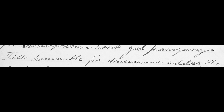

In [11]:
image = Image.open(train_df['file_name'][0]).convert('RGB')
image

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=config.batch_size)

In [13]:
from transformers import VisionEncoderDecoderModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Tried small then base
# model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-stage1")
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained("WinKawaks/vit-small-patch16-224", "KBLab/bert-base-swedish-cased")
model.to(device)

Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertLMHeadModel were not initialized from the model checkpoint at KBLab/bert-base-swedish-cased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(i

In [14]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = config.max_target_length
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [15]:
from evaluate import load
cer_metric = load("cer", trust_remote_code=True)

In [16]:
def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    _cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return _cer

In [17]:
from tqdm.notebook import tqdm

best_cer = float('inf')  # start with a high CER
learning_rates = [8.5e-5]
best_learning_rate = 0

for learning_rate in learning_rates:
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=config.weight_decay)
    for epoch in range(config.num_epochs):  # loop over the dataset multiple times
       # train
       model.train()
       train_loss = 0.0
       for batch in tqdm(train_dataloader):
          # get the inputs
          for k,v in batch.items():
            batch[k] = v.to(device)
    
          # forward + backward + optimize
          outputs = model(**batch)
          loss = outputs.loss
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
    
          train_loss += loss.item()
    
       print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))
    
       # evaluate
       model.eval()
       valid_cer = 0.0
       with torch.no_grad():
         for batch in tqdm(eval_dataloader):
           # run batch generation
           outputs = model.generate(batch["pixel_values"].to(device))
           # compute metrics
           cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
           valid_cer += cer
    
       valid_cer /= len(eval_dataloader)
       print("Validation CER:", valid_cer)
       print("learning rate:", learning_rate)
    
       # save the best model
       if valid_cer < best_cer:
           print("New best model found!")
           best_cer = valid_cer
           best_learning_rate = learning_rate
           model.save_pretrained("./custom_models/trocr_demoktatii_htr/e-d/v2.0.108/vision_model/")
           processor.save_pretrained("./custom_models/trocr_demoktatii_htr/e-d/v2.0.108/processor/")

print('Finished Training')
print(f"Best CER: {best_cer}")
print(f"Best learning rate: {best_learning_rate}")
wandb.finish()

  0%|          | 0/2113 [00:00<?, ?it/s]

C:\Users\salim\.conda\envs\ml\lib\site-packages\transformers\models\vit\modeling_vit.py:252: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Loss after epoch 0: 4.769944434813623


  0%|          | 0/529 [00:00<?, ?it/s]

C:\Users\salim\.conda\envs\ml\lib\site-packages\transformers\generation\utils.py:1364: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 104, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.7737562820988446
learning rate: 8.5e-05
New best model found!


  0%|          | 0/2113 [00:00<?, ?it/s]

Loss after epoch 1: 3.342238884428018


  0%|          | 0/529 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 104, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.7023603397799767
learning rate: 8.5e-05
New best model found!


  0%|          | 0/2113 [00:00<?, ?it/s]

Loss after epoch 2: 2.6545521116234148


  0%|          | 0/529 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 104, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.6472171536502965
learning rate: 8.5e-05
New best model found!


  0%|          | 0/2113 [00:00<?, ?it/s]

Loss after epoch 3: 2.1730869591546407


  0%|          | 0/529 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 104, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.6040297829404555
learning rate: 8.5e-05
New best model found!
Finished Training
Best CER: 0.6040297829404555
Best learning rate: 8.5e-05
